<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Fundamentals%20of%20AI%20Agents%20Using%20RAG%20and%20LangChain/RAG_on_Songs_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAG with PyTorch**
---

# Setup


In [ ]:
!pip install --user numpy
!pip install --user torch==2.2.0
!pip install --user sacremoses==0.1.1
!pip install --user torchtext
!pip install --user transformers==4.40.2
!pip install --user matplotlib==3.8.4
!pip install --user sentencepiece==0.2.0
!pip install --user scikit-learn==1.4.2

In [1]:
from tqdm import tqdm
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
# Helper Functions
def tsne_plot(data, plot):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42, perplexity=min(50, data.shape[0] - 1))  # Using 50 or less based on data size
    data_3d = tsne.fit_transform(data)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Assign colors for each point based on its index
    colors = plt.cm.rainbow(np.linspace(0, 1, len(data_3d)))
    for idx, point in zip(range(len(data_3d)), data_3d):
        ax.scatter(point[0], point[1], point[2], color=colors[idx], label=f'{plot} {idx+1}')

    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization of '+ plot +' Embeddings')
    plt.legend(title=plot +' Index', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

# Embeddings Using BERT and PyTorch Hub
### Loading Tokenizer

In [5]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
# Tokenizing
input_text = [("This is an example sentence for BERT embeddings.", "How do you like it "),("There are other models")]
input_ids = tokenizer.batch_encode_plus(input_text, add_special_tokens=True, padding=True, truncation=True)
input_ids

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


{'input_ids': [[101, 2023, 2003, 2019, 2742, 6251, 2005, 14324, 7861, 8270, 4667, 2015, 1012, 102, 2129, 2079, 2017, 2066, 2009, 102], [101, 2045, 2024, 2060, 4275, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [4]:
# Detokenizing
text = tokenizer.decode(input_ids['input_ids'][0])
print(text)
print(f"length {len(text.split())}")

[CLS] this is an example sentence for bert embeddings. [SEP] how do you like it [SEP]
length 16


In [6]:
input_ids['attention_mask']

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [8]:
input_ids_tensors = torch.tensor(input_ids['input_ids']).to(DEVICE)
mask_tensors = torch.tensor(input_ids['attention_mask']).to(DEVICE)

### Loading the BERT model

In [9]:
bert_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')
bert_model.to(DEVICE)
word_embding=bert_model(input_ids_tensors,mask_tensors)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Generating Aggregated Mean Embeddings Using BERT for RAG
It processes each pair of token IDs and attention masks from the input data, extracts word embeddings for non-padded tokens, and calculates their mean. The result is a list of mean embeddings for each sequence, which is then concatenated into a single tensor. This process allows for the generation of simplified yet informative representations of the input sequences, useful for tasks like clustering, similarity search, or as input to downstream models. Each document must be under 512 tokens.


In [10]:
# Initialize a list to store the mean embeddings for each input sequence
aggregated_mean_embeddings = []

# Loop over each pair of input_ids and attention_masks
for token_ids, attention_mask in tqdm(zip(input_ids['input_ids'], input_ids['attention_mask'])):
    # Convert list of token ids and attention mask to tensors
    token_ids_tensor = torch.tensor([token_ids]).to(DEVICE)
    attention_mask_tensor = torch.tensor([attention_mask]).to(DEVICE)
    print("token_ids_tensor shape:",token_ids_tensor.shape, attention_mask_tensor.shape)  # Print the shapes of the input tensors
    with torch.no_grad():  # Disable gradient calculations for faster execution
        # Retrieve the batch of word embeddings from the BERT model
        embeddings = bert_model(token_ids_tensor, attention_mask=attention_mask_tensor)[0].squeeze(0)
        print("Word embeddings shape:", embeddings.shape)

        # Count and print the number of zero-padding embeddings
        num_zero_paddings = (attention_mask_tensor == 0).sum().item()
        print("Number of zero padding embeddings:", num_zero_paddings)

        # Create a mask for positions that are not zero-padded
        valid_embeddings_mask = attention_mask_tensor[0] != 0
        print("valid_embeddings_mask:",valid_embeddings_mask)

        # Filter out the embeddings corresponding to zero-padded positions
        filtered_embeddings = embeddings[valid_embeddings_mask, :]
        print("Word embeddings after zero padding embeddings removed:", filtered_embeddings.shape)

        # Compute the mean of the filtered embeddings
        mean_embedding = filtered_embeddings.mean(axis=0)
        print("Mean embedding shape:", mean_embedding.shape)

        # Append the mean embedding to the list, adding a batch dimension
        aggregated_mean_embeddings.append(mean_embedding.unsqueeze(0))

# Concatenate all mean embeddings to form a single tensor
aggregated_mean_embeddings = torch.cat(aggregated_mean_embeddings)
print('All mean embeddings shape:', aggregated_mean_embeddings.shape)

0it [00:00, ?it/s]

token_ids_tensor shape: torch.Size([1, 20]) torch.Size([1, 20])


2it [00:00,  3.95it/s]

Word embeddings shape: torch.Size([20, 768])
Number of zero padding embeddings: 0
valid_embeddings_mask: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])
Word embeddings after zero padding embeddings removed: torch.Size([20, 768])
Mean embedding shape: torch.Size([768])
token_ids_tensor shape: torch.Size([1, 20]) torch.Size([1, 20])
Word embeddings shape: torch.Size([20, 768])
Number of zero padding embeddings: 14
valid_embeddings_mask: tensor([ True,  True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])
Word embeddings after zero padding embeddings removed: torch.Size([6, 768])
Mean embedding shape: torch.Size([768])
All mean embeddings shape: torch.Size([2, 768])


The above code is converted to the function ```aggregate_embeddings``` that takes token indices and their corresponding attention masks, and uses a BERT model to convert these tokens into word embeddings. It then filters out the embeddings for zero-padded tokens and computes the mean embedding for each sequence. This helps in reducing the dimensionality of the data while retaining the most important information from the embeddings.


In [11]:
def aggregate_embeddings(input_ids, attention_masks, bert_model=bert_model):
    """
    Converts token indices and masks to word embeddings, filters out zero-padded embeddings,
    and aggregates them by computing the mean embedding for each input sequence.

    """
    mean_embeddings = []
    # Process each sequence in the batch
    print('number of inputs',len(input_ids))
    for input_id, mask in tqdm(zip(input_ids, attention_masks)):
        input_ids_tensor = torch.tensor([input_id]).to(DEVICE)
        mask_tensor = torch.tensor([mask]).to(DEVICE)

        with torch.no_grad():
            # Obtain the word embeddings from the BERT model
            word_embeddings = bert_model(input_ids_tensor, attention_mask=mask_tensor)[0].squeeze(0)

            # Filter out the embeddings at positions where the mask is zero
            valid_embeddings_mask=mask_tensor[0] != 0
            valid_embeddings = word_embeddings[valid_embeddings_mask,:]
            # Compute the mean of the filtered embeddings
            mean_embedding = valid_embeddings.mean(dim=0)
            mean_embeddings.append(mean_embedding.unsqueeze(0))

    # Concatenate the mean embeddings from all sequences in the batch
    aggregated_mean_embeddings = torch.cat(mean_embeddings)
    return aggregated_mean_embeddings

Further simplify the process with the function ```text_to_emb``` which is designed to convert a list of text strings into their corresponding embeddings using a pre-defined tokenizer and calling ```aggregate_embeddings```.


In [12]:
def text_to_emb(list_of_text,max_input=512):
    data_token_index  = tokenizer.batch_encode_plus(list_of_text, add_special_tokens=True,padding=True,truncation=True,max_length=max_input)
    question_embeddings=aggregate_embeddings(data_token_index['input_ids'], data_token_index['attention_mask'])
    return question_embeddings

# Convert Questions and The Song Lyrics into Embeddings


In [13]:
import re
def process_song(song):
    # Remove line breaks from the song
    song_new = re.sub(r'[\n]', ' ', song)

    # Remove single quotes from the song
    song_new = [song_new.replace("\'", "")]

    return song_new

In [14]:
# Questions
song_questions = [
    "Does this song contain any violent themes, such as references to guns, killing, or physical aggression? Example: Does the song describe or promote physical violence, like fighting or shootings?",
    "Are there any explicit lyrics or bad words used in this song that might be considered offensive or inappropriate? Example: Does the song use language commonly recognized as profanity or derogatory terms?",
    "Is the overall content of this song suitable for children, considering its themes, language, and messages? Example: Are there elements in the song that could be deemed too mature or unsuitable for young listeners?",
    "Does this song explicitly mention weapons, such as guns, knives, or other similar items? Example: Are specific types of weapons described or glorified in the lyrics?",
    "Are the messages conveyed in this song positive and uplifting for children? Example: Does the song promote values like kindness, friendship, and positivity?",
    "Does this song include any sexual content, references to sexual behavior, or suggestive language? Example: Are there lyrics that explicitly or implicitly discuss sexual themes or experiences?",
    "Does this song offer any educational value, such as teaching the alphabet, basic math, or other learning content? Example: Are there educational segments in the song that could help children learn fundamental skills like the ABCs or counting?",
    "Does this song promote emotional resilience and social skills among children? Example: Does the song include themes of overcoming challenges or building friendships?"
]

embeddings_questions=street=text_to_emb(song_questions)

number of inputs 8


8it [00:02,  3.21it/s]


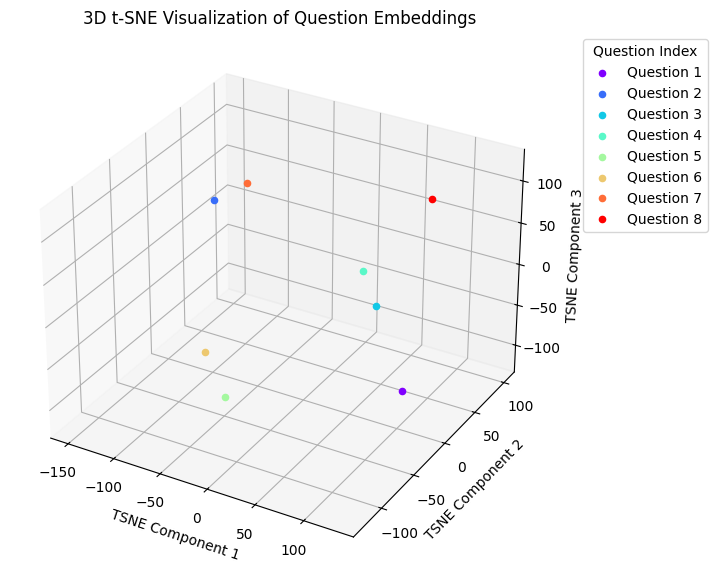

In [15]:
# Visualize tsne Plot
tsne_plot(embeddings_questions, "Question")

In [16]:
# Responses
yes_responses = [
    "Yes, this song contains violent themes, including references to guns, killing, or physical aggression, and is not suitable for children.",
    "Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.",
    "No, the overall content of this song is not suitable for children as it includes themes, language, and messages that are too mature or unsuitable for young listeners.",
    "Yes, this song explicitly mentions weapons, such as guns and knives, which could be disturbing or inappropriate for children’s entertainment.",
    "Yes, the messages conveyed in this song are positive and uplifting, promoting values like kindness, friendship, and positivity, beneficial for children.",
    "Yes, this song includes sexual content and references to sexual behavior or suggestive language, which are inappropriate for a child-friendly environment.",
    "Yes, this song offers significant educational value, including segments that teach the alphabet, basic math, and other learning content, making it both fun and educational for children.",
    "Yes, this song promotes emotional resilience and social skills, incorporating themes about overcoming challenges and building friendships, which are essential for children's development."
]
embeddings_responses = text_to_emb(yes_responses)

number of inputs 8


8it [00:02,  3.71it/s]


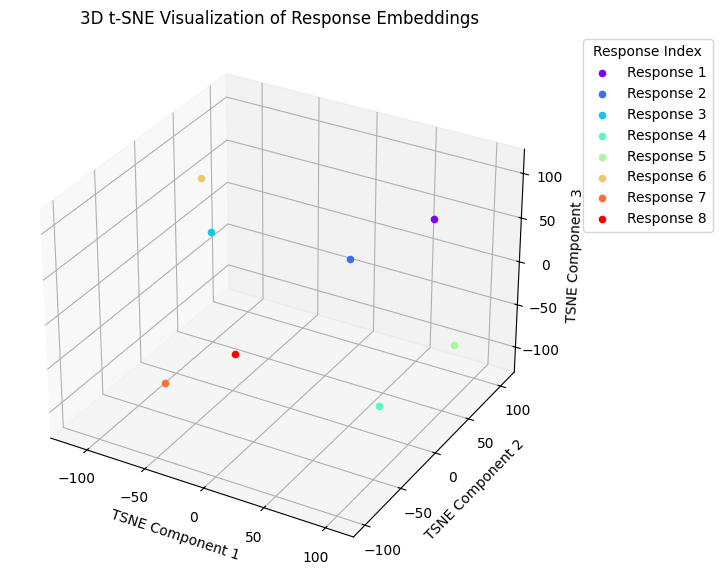

In [17]:
tsne_plot(embeddings_responses, "Response")

In [18]:
sesame_street = """
Sunny day
Sweepin' the clouds away
On my way to where the air is sweet
Can you tell me how to get
How to get to Sesame Street?

Come and play
Everything's A-okay
Friendly neighbors there
That's where we meet
Can you tell me how to get
How to get to Sesame Street?

It's a magic carpet ride
Every door will open wide
To happy people like you
Happy people like
What a beautiful

Sunny day
Sweepin' the clouds away
On my way to where the air is sweet
Can you tell me how to get
How to get to Sesame Street?
How to get to Sesame Street?
How to get to Sesame Street?
How to get to Sesame Street?
How to get to Sesame Street?
"""

In [19]:
song_sesame_street= process_song(sesame_street)
embeddings_sesame_street=text_to_emb(song_sesame_street)

number of inputs 1


1it [00:00,  1.70it/s]


In [20]:
my_shoe_lyrics="""Barney is a dinosaur from our imagination
And when he's tall
He's what we call a dinosaur sensation
Barney's friends are big and small
They come from lots of places
After school they meet to play
And sing with happy faces
Barney shows us lots of things
Like how to play pretend
ABC's, and 123's
And how to be a friend
Barney comes to play with us
Whenever we may need him
Barney can be your friend too
If you just make-believe him!"""

In [21]:
my_shoe_lyrics= process_song(my_shoe_lyrics)
embeddings_my_shoe=text_to_emb(my_shoe_lyrics)

number of inputs 1


1it [00:00,  1.96it/s]


In [24]:
songs = [ song_sesame_street, my_shoe_lyrics]
embeddings = [text_to_emb(song) for song in songs]
all_embeddings = np.vstack(embeddings)

number of inputs 1


1it [00:00,  1.79it/s]


number of inputs 1


1it [00:00,  2.49it/s]


Using rag to identify Songs

In [29]:
def RAG_QA(embeddings_questions, embeddings, n_responses=3):
    # Calculate the dot product between the question embeddings and the provided embeddings (transpose of the second matrix for proper alignment).
    dot_product = embeddings_questions @ embeddings.T

    # Reshape the dot product results to a 1D tensor for easier processing.
    dot_product = dot_product.reshape(-1)

    # Sort the indices of the dot product results in descending order (setting descending to False should be True for typical similarity tasks).
    sorted_indices = torch.argsort(dot_product, descending=True)

    # Convert sorted indices to a list for easier iteration.
    sorted_indices = sorted_indices.tolist()

    # Print the top 'n_responses' responses from the sorted list, which correspond to the highest dot product values.
    for index in sorted_indices[:n_responses]:
        print(yes_responses[index])

In [30]:
RAG_QA(embeddings_questions, embeddings_sesame_street)

Yes, the messages conveyed in this song are positive and uplifting, promoting values like kindness, friendship, and positivity, beneficial for children.
Yes, this song offers significant educational value, including segments that teach the alphabet, basic math, and other learning content, making it both fun and educational for children.
Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.


In [32]:
RAG_QA(embeddings_questions, embeddings_my_shoe)

Yes, this song offers significant educational value, including segments that teach the alphabet, basic math, and other learning content, making it both fun and educational for children.
Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.
Yes, the messages conveyed in this song are positive and uplifting, promoting values like kindness, friendship, and positivity, beneficial for children.
